# Ensemble Learning 

The goal of ensemble methods is to combine different classifiers into a metaclassifier that has better generalization performance than each individual classifier alone<sup>4</sup>.

Most popular ensemble methods use the majority voting principle.

In [54]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
from IPython.display import Image
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings # prevent warnings
import joblib # saving models
import itertools
from scipy.stats.distributions import uniform, loguniform
from scipy.stats import distributions

matplotlib.rcParams['animation.embed_limit'] = 30000000.0
plt.rcParams['figure.dpi'] = 120

image_dir = os.path.join(os.getcwd(),"Images")
data_dir = os.path.join(os.getcwd(),"..","Data")

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=42)

## Majority Voting

Aggregation can be done by simply selecting the class label that has been predicted by the majority of the classifiers (more than 50% of votes) for 'hard voting'.

Majority vote refers to binary class decisions but can be generalized to a multi-class setting using 'plurality voting'<sup>4</sup>.

To predict a class label via simple majority or plurality voting, we can combine the predicted class labels of each individual classifier, $C_m$, and select the class label, $\hat y$, that received the most votes<sup>4</sup>.


We can write the weighted majority vote as follows<sup>4</sup>:

$\hat y = \text{arg} {\text{max} \atop i} \sum^m_{j=1}W_jI_A(C_j(x)=i)$

where $w_j$ is a weight associated with a base classifier, $C_j$ ; $\hat y$ is the predicted class label of the ensemble; $A$ is the set of unique class labels; $I_A$ is the characteristic function or indicator function, which returns 1 if the predicted class of the $j$th classifier matches i(C_j(x)=i. For equal weights, we can simplify this equation and write it as follows:

$\hat y = mode\{C_1(x), C_2(x),...,C_m(x)\}$

In binary classification (-1,1) we can therefore write the majority vote prediction as<sup>4</sup>:

$C(x) = \text{sign}\left[ \sum^m_jC_j(x)\right] = \left\{{1 \: \text{if}\: \sum_j C_j(x) \geq 0  \atop -1 \quad\text{otherwise}} \right\}$

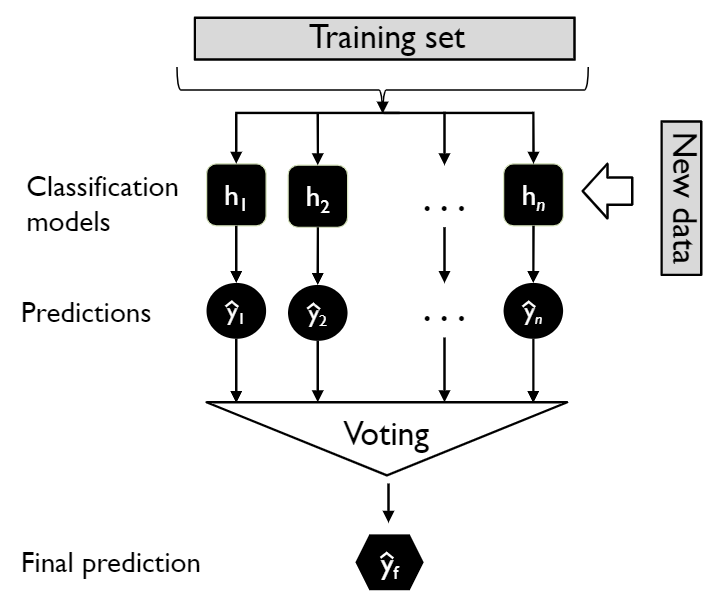

In [67]:
# From https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf
Image(os.path.join(image_dir, "majority_voting.png"), width=600)

__NOTES__

- Scikit-learn has a VotingClassifier where multipule classification pipelines can be combined to create an even better classifier that aggregates predictions.
- Scikit-learn uses the `predict_proba` method to compute class probabilities. _"In decision trees, the probabilities are calculated from a frequency vector that is created for each node at training time. The vector collects the frequency values of each class label computed from the class label distribution at that node. Then, the frequencies are normalized so that they sum up to 1."_

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017

Particular classifiers return the probability of a predicted class label and this can be used for 'soft voting' instead of class labels<sup>4</sup>. The modified version of the majority vote for predicting class labels from probabilities can be written as:

$\hat y = \text{arg} {\text{max} \atop i} \sum^m_{j=1}w_jp_{ij}$,

where $p_{ij}$ is the predicted probability of the $j$th classifier for class label $i$.

Soft voting often achives a higher performance than hard voting because highly confident votes are given more weight<sup>3</sup>.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.decomposition import PCA
import timeit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

RANDOM_STATE=42

clf1 = Pipeline([('scl', StandardScaler()),
                 ('clf', SVC(kernel='rbf', 
                             gamma='auto',
                             random_state=RANDOM_STATE, 
                             probability = True))])

clf2 = Pipeline([('scl', StandardScaler()),
                 ('clf', LogisticRegression(solver='liblinear',
                                            random_state=RANDOM_STATE))
])

clf3 = DecisionTreeClassifier(random_state=RANDOM_STATE)

clf_labels = ['SVM', # Support Vector Machine
              'LR', # LogisticRegression
              'DT'] # Decision Tree

# Majority Rule Voting
hard_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
                                           (clf_labels[1],clf2),
                                           (clf_labels[2],clf3)],
                              voting='hard')

soft_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
                                           (clf_labels[1],clf2),
                                           (clf_labels[2],clf3)],
                               voting='soft')

clf_labels += ['Hard Majority Voting', 'Soft Majority Voting']
all_clf = [clf1, clf2, clf3, hard_mv_clf, soft_mv_clf]

for clf, label in zip(all_clf, clf_labels): 
    clf.fit(X_train, y_train)

    print(color.BOLD+color.UNDERLINE+label+color.END)
    print("Training ACC Score: %0.3f"
          % accuracy_score(y_train, clf.predict(X_train)))
    print("Validation ACC Score: %0.3f"
          % accuracy_score(y_val, clf.predict(X_val)))
    print()

SVM
Training ACC Score: 0.989
Validation ACC Score: 0.956

LR
Training ACC Score: 0.992
Validation ACC Score: 0.956

DT
Training ACC Score: 1.000
Validation ACC Score: 0.901

Hard Majority Voting
Training ACC Score: 0.995
Validation ACC Score: 0.956

Soft Majority Voting
Training ACC Score: 0.997
Validation ACC Score: 0.967



## Averaging Methods

Averaging methods build several _separate_ estimators and then, as their name suggets, average their predictions. 

Averaging methods generally work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers. This increases the chance they each make different types of errors which in combination will improve the overall accuracy<sup>3</sup>.

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

__NOTES__
- __High Variance__ means if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. 
- __Low Variance__ means a procedure will yield similar results if applied repeatedly to distinct data sets.
- Decision trees typically suffer from _high variance_.
- Linear regression tends to have low variance, if the ratio of n to p is moderately large.

### Bootstrap (A Quick Recap)

__TODO__
- chapter 5 of James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

### Bagging
A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. This reduces _variance_ of an estimator so can be a simple way to reduce overfitting and increase prediction accuracy<sup>1</sup>. 

This is because the variance of the mean $\bar Z$ of $n$ independent observations, $Z_1,...,Z_n$, is given by $\sigma^2/n$; meaning averaging a set of observations reduces variance. Can can use this by taking many separate training sets, $B$, from the population, building a separate prediction model using each training set, $\hat f^1(x),\hat f^2(x),...,\hat f^B(x)$, and average the resulting predictions<sup>2</sup>:

$\hat f_{avg}(x)=\frac{1}{B}\sum_{b=1}^B\hat f^b(x)$.

However we generally do not have access to multiple training sets so instead we can bootstrap by taking repeated samples from a (single) training data set to create multiple bootstrapped training data sets, $B$. We then train our method on the $b$th bootstrapped training set to get $f^{∗b}(x)$ , and finally average all the predictions, to obtain<sup>2</sup>:

$\hat f_{bag}(x) = \frac{1}{B}\sum_{b=1}^B\hat f^{∗b}(x)$.

---
1. https://scikit-learn.org/stable/modules/ensemble.html

2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

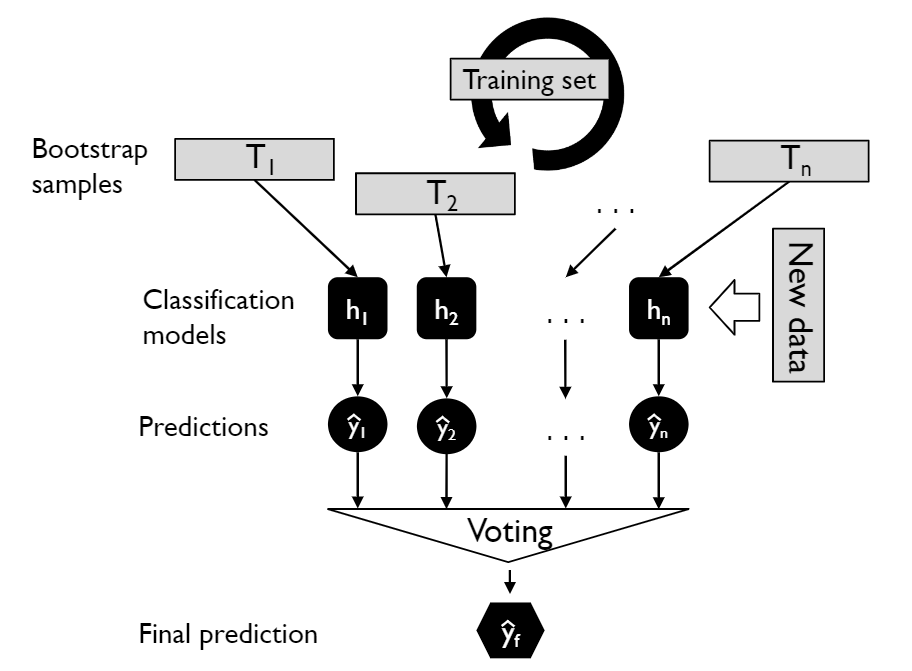

In [68]:
# From https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf
Image(os.path.join(image_dir, "bagging.png"), width=600)

Specifically, bagging is when sampling is produced with replacement<sup>2</sup>, and without replacement being called _pasting_<sup>3</sup>. 

Pasting is designed to use smaller sample sizes than the training dataset in cases where the training dataset does not fit into memory<sup>3</sup>.

Both bagging and pasting allow training to be sampled several times across multipule predictors, with bagging only allowing several samples for the same predictor <sup>4</sup>.

---
2. Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140.
3. Breiman, L. (1999). Pasting small votes for classification in large databases and on-line. Machine learning, 36(1-2), 85-103.
4. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

__NOTES__

- If we wanted to use pasting we would just set `bootstrap=False`.

In [33]:
from sklearn.ensemble import BaggingClassifier
example_np = pd.DataFrame(range(10)).values

bag = BaggingClassifier(base_estimator=clf3,
                        n_estimators=5, 
                        random_state=42,
                        max_samples = 0.8,
                        bootstrap=True
                       ).fit(example_np,example_np.ravel())

bagged_samples = bag.estimators_samples_

bag.set_params(bootstrap=False).fit(example_np,example_np.ravel())

pasting_samples = bag.estimators_samples_

print(color.BOLD+color.UNDERLINE+"Original Data"+color.END)
display(example_np.flatten())
print(color.BOLD+color.UNDERLINE+"Bagging (0.8 Samples)"+color.END)
display(bagged_samples)
print(color.BOLD+color.UNDERLINE+"Pasting (0.8 Samples)"+color.END)
display(pasting_samples)

Original Data


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Bagging (0.8 Samples)


[array([9, 2, 9, 7, 7, 8, 3, 2]),
 array([7, 3, 7, 3, 9, 5, 3, 9]),
 array([6, 0, 7, 7, 9, 8, 5, 8]),
 array([0, 5, 7, 4, 1, 3, 6, 2]),
 array([6, 9, 6, 3, 3, 8, 3, 7])]

Pasting (0.8 Samples)


[array([6, 7, 5, 8, 3, 0, 4, 1]),
 array([0, 4, 5, 6, 2, 1, 8, 9]),
 array([5, 3, 9, 4, 8, 2, 1, 7]),
 array([9, 3, 6, 1, 8, 4, 2, 7]),
 array([1, 5, 4, 2, 0, 8, 7, 3])]

In practice, _bagging_ tends to work best with complex models<sup>1</sup>, so although bagging is useful when applied to regression methods, they are particularly useful for decision trees<sup>2</sup>.

Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

These trees are grown deep, and are not pruned so each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance.

To apply bagging to __regression trees__, we simply:
1. construct $B$ regression trees using $B$ bootstrapped training sets, 
2. average the resulting predictions. 

To apply bagging to __decision trees__, we simply:
1. construct $B$ decision trees using $B$ bootstrapped training sets, 
2. take a majority vote of the resulting predictions.

---
1. https://scikit-learn.org/stable/modules/ensemble.html
2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

__Notes__
- _boosting_ will generally work better with weak models.
- _[Explanation of bias]_
- Have a look at _Majority Voting_ from the last lecture.

#### Out-of-Bag Error Estimation
Using a bagged model means we can get a validation/test error without using cross-validation.

On average, each bagged tree uses around two-thirds of the observations<sup>1, REF</sup>, therefore we can predict these out-of-bag (OOB) observations using only the trees that were not fit using those observations.

With a sufficiently amount of bags, OOB error is virtually equivalent to leave-one-out cross-validation error, which is convenient when performing bagging on large data sets for which cross-validation would be computationally onerous<sup>1</sup>.

---
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__NOTES__

- we use `oob_score = True`

#### Variable Importance Measures

Bagging improves prediction accuracy at the expense of interpretability.

However we can use the feature importance method as previously discussed, to get an overall summary of the importance of each predictor across trees.

__NOTES__
- Bagging can be used with most classifiers, although you can only assess feature importances if a method provides a `feature_importances_`.
- _"Recall that one of the advantages of decision trees is the attractive and easily interpreted diagram that results... However, when we bag a large number of trees, it is no longer possible to represent the resulting statistical learning procedure using a single tree, and it is no longer clear which variables are most important to the procedure."_<sup>1</sup>

---
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

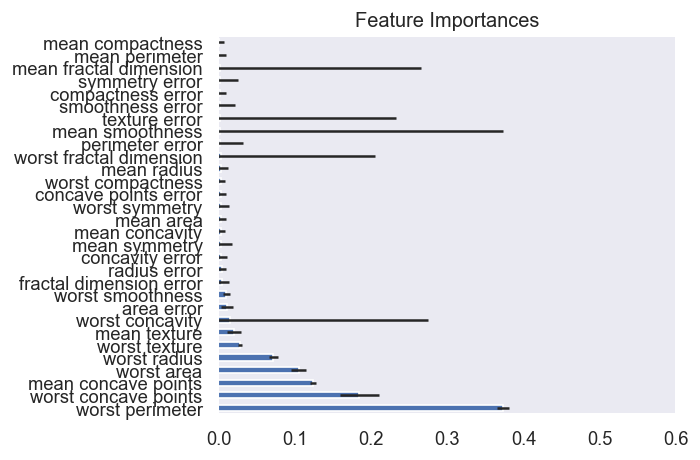

In [12]:
bag = BaggingClassifier(base_estimator=clf3, 
                        n_estimators=100, 
                        max_samples=0.8, 
                        max_features=1., 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        oob_score=True, 
                        warm_start=False,
                        n_jobs=-1, 
                        random_state=42)
bag.fit(X.values, y.values)

# get the importances for the features
importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

importances_sd = np.std([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

importances_series = pd.Series(importances,index=X.columns).sort_values(ascending = False)

# plot the important features
importances_series.plot.barh(legend =False, grid=False, xerr=importances_sd)
plt.title('Feature Importances')

plt.xlim(0,0.6)
plt.tight_layout()

#plt.savefig('forest_importances.png', dpi=300)
plt.show()

### Random Forests

_"Random forests are among the most widely used machine learning algorithm, probably due to their relatively good performance “out of the box” and ease of use (not much tuning required to get good results)."_<sup>web1</sup>

Random forests are essentally bagged tree classifiers, but decorrelate the trees by using a random sample of features each time a split in a tree is considered. 

The random forest algorithm can therefore be summarized in four steps<sup>1</sup>:

__Algorithm. Random Forests__
> 1. Draw a random bootstrap sample of size $n$.
> 2. Grow a decision tree from the bootstrap sample. At each node:
>
>    a. Randomly select $d$ features without replacement (typically the square root of the total number of predictors).
>    
>    b. Split the node using the feature that provides the best split according to the objective function.
>
>3. Repeat the steps above $k$ times.
>4. Aggregate the prediction by each tree to assign the class label by majority vote.

---
1. Raschka2017

web1. https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf

By not allowing the model to use the majority of the available predictors, we ensure the bagged trees look different from each other. If there is a particularly strong set of predictors in the data, then without randomly selecting features, the bagged trees will look quite similar to each other and predictions will be highly correlated. Averaging highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities<sup>2</sup>. 

---
1. Raschka2017
2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__Summary__

Random forests fit decision trees on different bootstrap samples, and for each decision tree, select a random subset of features at each node to decide upon the optimal split. The feature subset to consider at each node is a hyperparameter that we can tune<sup>web1</sup>.

__NOTES__
- Instead of using majority vote, as was done in the origional publication<sup>2</sup>, in Sklearn the `RandomForestClassifier` averages the probabilistic prediction.
- Remember we cannot use `graphviz` or `sklearn.tree.plot_tree` on the whole forest as we did for the trees, as each tree is built differently.
- if a random forest is built using $d$ = $D$ (all features), then this is simply bagging.
- Rather than using the bagging method above we can use one of the inbuilt methods Sklearn has specifically designed for fitting an ensemble of trees. Its generally quicker as can be seen below...

__TODO__
- okay mabe not on small data then? Maybe make a graph as data increases using `make_classification`

---
2. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001

web1. https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf

__Does random forest select a subset of features for every tree or every node?__

[BELOW COPIED FROM https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf - reword!]

Earlier random decision forests by Tin Kam Ho<sup>9</sup> used the “random subspace method,” where each tree got a random subset of features.
> “The essence of the method is to build multiple trees in randomly selected subspaces of the feature space.” – Tin Kam Ho

However, a few years later, Leo Breiman<sup>10</sup> described the procedure of selecting different subsets of features for each node (while a tree was given the full set of features) — Leo Breiman’s formulation has become the “trademark” random forest algorithm that we typically refer to these days when we speak of “random forest:”
>“. . . random forest with random features is formed by selecting at random, at each node, a small group of input variables to split on.”

---

9. Tin Kam Ho. “Random decision forests”. In: Document analysis and recognition, 1995., proceedings of
the third international conference on. Vol. 1. IEEE. 1995, pp. 278–282.

10. Leo Breiman. “Random forests”. In: Machine learning 45.1 (2001), pp. 5–32.

In [14]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_samples=0.8,
                            max_features = 2,
                            random_state=42,
                            n_jobs=-1)

RF.fit(X.values, y.values)

RandomForestClassifier(max_features=2, max_samples=0.8, n_jobs=-1,
                       random_state=42)

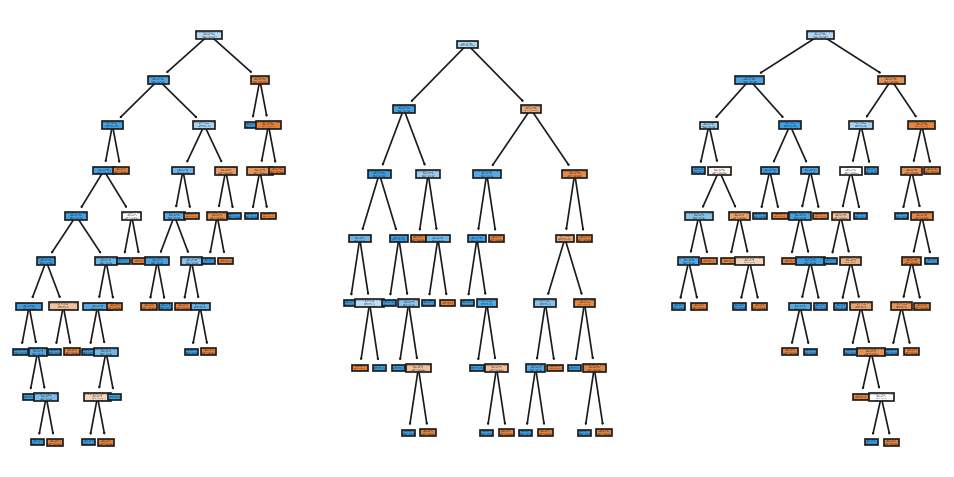

In [17]:
plot_trees = 3
fig, axes = plt.subplots(ncols=plot_trees, figsize=(10,5))
with plt.style.context("classic"):
    for i in range(plot_trees):
        plt.sca(axes[i])
        plot_tree(RF.estimators_[i],
                  feature_names=X.columns, 
                  class_names=load_breast_cancer().target_names,
                  filled = True)
    plt.show()

__TODO__
- maybe change some settings here `max_features = 2` is a bit low

In [71]:
from math import sqrt

RF = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_samples=0.8,
                            max_features = 2,
                            random_state=42,
                            n_jobs=-1)

DT = DecisionTreeClassifier(criterion='gini',
                            random_state=42)
bag = BaggingClassifier(base_estimator=DT, 
                        n_estimators=100, 
                        max_samples=0.8, 
                        max_features=2, 
                        bootstrap=True, 
                        bootstrap_features=True, 
                        oob_score=False, 
                        warm_start=False,
                        n_jobs=-1, 
                        random_state=42)

print(color.BOLD+color.UNDERLINE+"Bagged Trees"+color.END)
%timeit -n 10 bag.fit(X.values, y.values)
print(color.BOLD+color.UNDERLINE+"Random Forest"+color.END)
%timeit -n 10 RF.fit(X.values, y.values)

Bagged Trees
The slowest run took 5.51 times longer than the fastest. This could mean that an intermediate result is being cached.
101 ms ± 87.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Random Forest
161 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Feature Importance

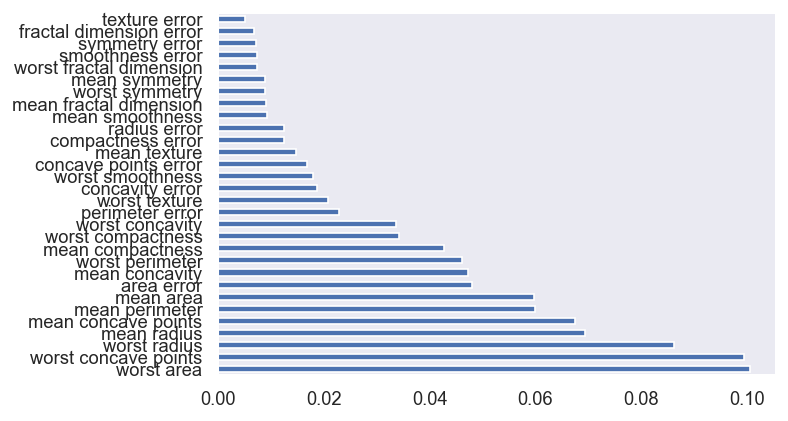

In [75]:
# get the importances for the features
importances = RF.feature_importances_

importances_series = pd.Series(importances,index=X.columns).sort_values(ascending = False)

# plot the important features
importances_series.plot.barh(legend =False, grid=False)
plt.show()

### Permutation Importance

_"impurity-based feature importances can be misleading for high cardinality features (many unique values). See `sklearn.inspection.permutation_importance` as an alternative"_ https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance

Lets look at how a descion boundary created by a bagged tree could generalise better than a single tree.

__todo__
- maybe in application section? Comparing different methods

In [38]:
def hyper_search(model, params, X, y, save_path, n_iter=60, random_state=42, overwrite=False):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, random_state=random_state)
        
        start = time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            models.fit(X, y)
        
        print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

cancer_features = ['mean radius','mean smoothness']
# specify parameters and distributions to sample from
param_grid = {"min_samples_leaf":list(range(1,15))}

lsamples_gs = hyper_search(DT, param_grid, X[cancer_features].values, y,
                           os.path.join(os.getcwd(), "Models", "lsamples_gs_object.pkl"))

pd.DataFrame(lsamples_gs.cv_results_).sort_values("rank_test_score")[["param_min_samples_leaf", "mean_test_score", "std_test_score"]].head()

,param_min_samples_leaf,mean_test_score,std_test_score
12,13,0.892796,0.037784
13,14,0.892796,0.037784
10,11,0.889287,0.041346
8,9,0.887549,0.043764
9,10,0.887533,0.040511


In [65]:
# specify parameters and distributions to sample from
param_grid = {"n_estimators":range(2,1000),
              "max_samples":uniform(0.05, 1.)}

rf_gs = hyper_search(RF, param_grid, X[cancer_features].values, y,
                     os.path.join(os.getcwd(), "Models", "rf_gs_object.pkl"), 
                     n_iter=15, random_state=1, overwrite=False)

pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score")[["param_n_estimators", "param_max_samples", "mean_test_score", "std_test_score"]].head()

Randomsearch took 53.91 seconds for 15 candidates


,param_n_estimators,param_max_samples,mean_test_score,std_test_score
12,866,0.190387,0.905123,0.033407
4,751,0.23626,0.903369,0.033675
8,492,0.254452,0.903354,0.032782
3,131,0.286089,0.899798,0.033650
2,849,0.352333,0.898075,0.035759


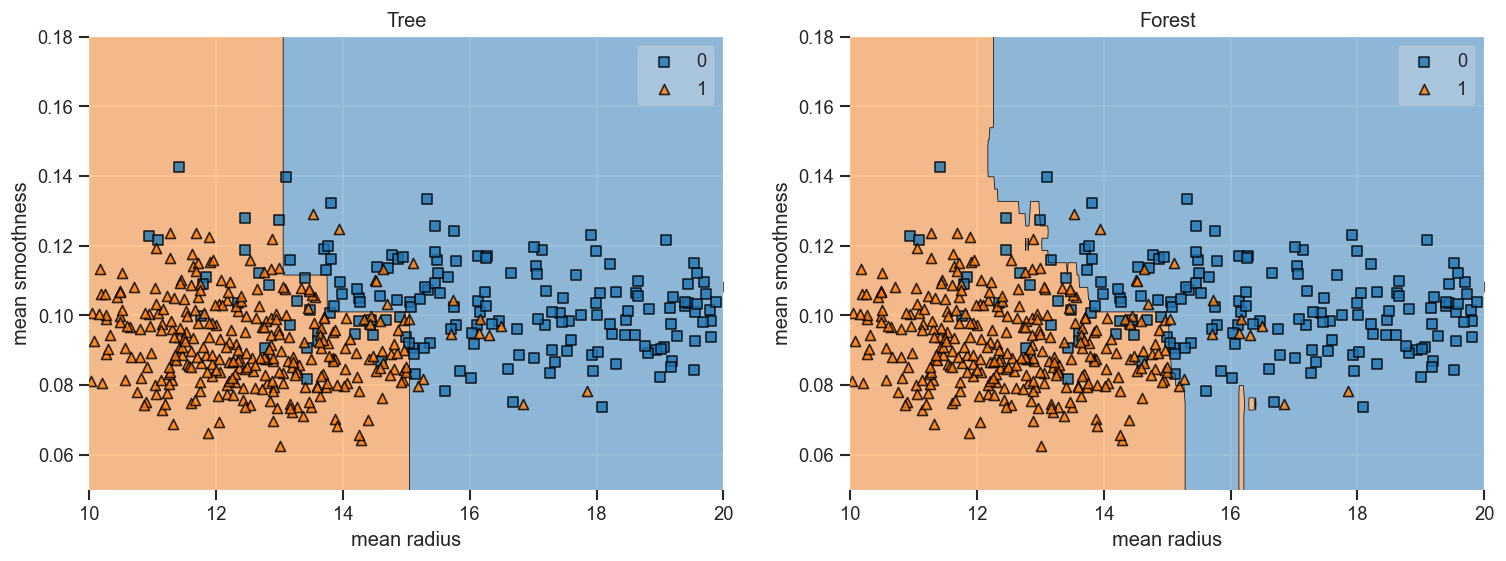

In [66]:
tree_dict = {'Tree':lsamples_gs.best_estimator_, 'Forest':rf_gs.best_estimator_}

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
for i, classifier_name in enumerate(tree_dict):
    plt.sca(axes[i])

    plot_decision_regions(X[cancer_features].values, y.values,
                          clf = tree_dict[classifier_name])

    plt.xlabel(cancer_features[0]) 
    plt.ylabel(cancer_features[1])

    plt.title(classifier_name)
    plt.ylim([0.05,0.18])
    plt.xlim([10,20])
plt.show()

#### Extremely Randomized Trees
As averaging methods work best when the predictors are as independent as possible<sup>2</sup>, we may specifically want our trees in our ensemble to be more independent. 

An extratree is similar to a tree classifier except it more randomized and thusly produces more complex trees. 

Instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.

When used in an ensemble, this usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias<sup>2</sup>.

---
1. Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. Machine learning, 63(1), 3-42.
2. https://scikit-learn.org/stable/modules/ensemble.html
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

In [22]:
from sklearn.tree import ExtraTreeClassifier

ET = ExtraTreeClassifier(criterion='gini',
                         random_state=42,
                         max_depth = None)

ET.fit(X.values, y.values)

ExtraTreeClassifier(random_state=42)

As we can see how just one tree looks, this is a very complex model!

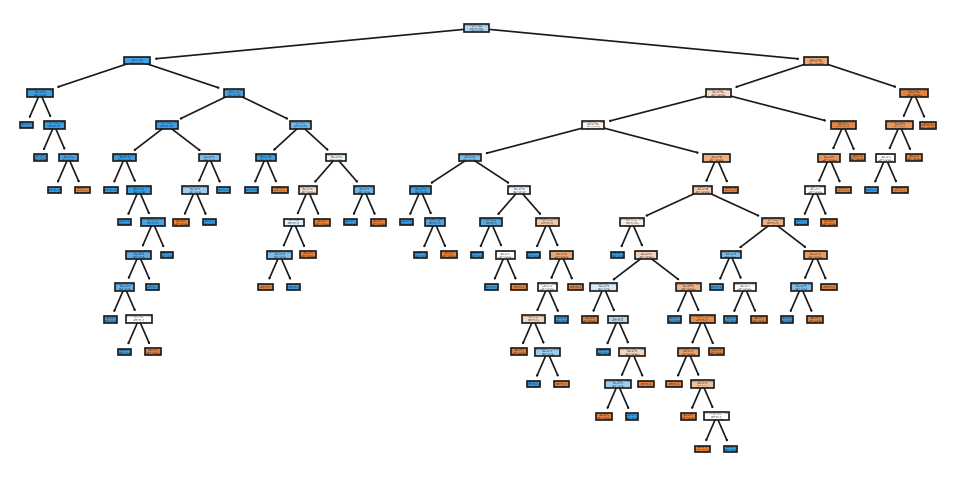

In [24]:
fig, axes = plt.subplots(figsize=(10, 5))
with plt.style.context("classic"):
    plot_tree(ET,
              feature_names=X.columns, 
              class_names=load_breast_cancer().target_names,
              filled = True)
    plt.show()

# Associated Exercises

Now might be a good time to try exercises X-X.

# References
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
2. Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [69]:
!jupyter nbconvert 2_Ensemble_Averaging.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 2_Ensemble_Averaging.ipynb to slides
[NbConvertApp] Writing 1202897 bytes to 2_Ensemble_Averaging.slides.html
